In [104]:
import torch as th
import torchvision as tv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [117]:
#pipeline = tv.transforms.Compose([tv.transforms.ToTensor(),tv.transforms.Lambda(lambda x: x.reshape(-1)),])
#ds_train = tv.datasets.MNIST(root='.', transform=pipeline, download=True)
#ds_test = tv.datasets.MNIST(root='.', train=False, transform=pipeline, download=True)
ds_train = tv.datasets.MNIST(root='.', download=True)
ds_test = tv.datasets.MNIST(root='.', train=False, download=True)

In [124]:
np_x_train = np.array([np.array(x[0]) for x in ds_train])
np_x_test = np.array([np.array(x[0]) for x in ds_test])


(60000, 28, 28)

In [126]:
np_x_train = np_x_train / 255.
np_x_test = np_x_test / 255.

In [136]:
# re-prep the datasets
ds_train = th.utils.data.TensorDataset(th.tensor(np_x_train.reshape(-1,28*28), device=th.device('cuda'), dtype=th.float32))
ds_test = th.utils.data.TensorDataset(th.tensor(np_x_test.reshape(-1,28*28), device=th.device('cuda'), dtype=th.float32))

torch.Size([256, 784])

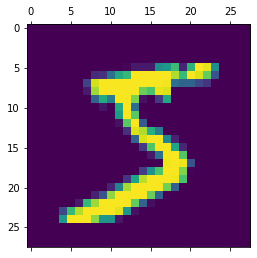

In [152]:
BATCH_SIZE = 256
dl = th.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE)
for x, in dl:
    break
plt.matshow(x[0].cpu().numpy().reshape(28,28))
x.shape


In [153]:
len(dl)

235

In [154]:
class SimpleAutoEncoder(th.nn.Module):
    def __init__(self, inp_size, encoding=[512, 256], embedding_size=32):
        super().__init__()
        self.enc_layers = th.nn.ModuleList()
        prev_units = inp_size
        for units in encoding:
            self.enc_layers.append(th.nn.Linear(prev_units, units))
            self.enc_layers.append(th.nn.ReLU())
            prev_units = units
        self.embedding = th.nn.Linear(prev_units, embedding_size)

        prev_units = embedding_size
        self.dec_layers = th.nn.ModuleList()
        for units in reversed(encoding):
            self.dec_layers.append(th.nn.Linear(prev_units, units))
            prev_units = units
            self.dec_layers.append(th.nn.ReLU())
        
        self.readout = th.nn.Linear(prev_units, inp_size)
        return
        
    def encoder(self, inputs):
        if len(inputs.shape) > 2: 
            # do NOT use this approach in real-life models.
            # instead use pre-processing reshaping (via tv pre-proc pipeline or manual)
            th_x = inputs.view(inputs.shape[0], -1)
        else:
            th_x = inputs
            
        for layer in self.enc_layers:
            th_x = layer(th_x)
        return self.embedding(th_x)
    
    def decoder(self, inputs):
        th_x = inputs
        for layer in self.dec_layers:
            th_x = layer(th_x)
        return self.readout(th_x)
    
    def forward(self, inputs):
        th_x = self.encoder(inputs)
        return self.decoder(th_x)
model = SimpleAutoEncoder(28*28).cuda()
model        

SimpleAutoEncoder(
  (enc_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (embedding): Linear(in_features=256, out_features=32, bias=True)
  (dec_layers): ModuleList(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
  )
  (readout): Linear(in_features=512, out_features=784, bias=True)
)

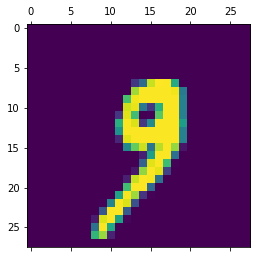

In [155]:
plt.matshow(ds_test[1000][0].cpu().numpy().reshape(28,28))

In [156]:
def th_eval(model, ds, idx):
    model.eval()
    with th.no_grad():
        th_yh = model(ds[idx][0].unsqueeze(0))
    plt.figure()
    plt.subplot(121)
    plt.imshow(ds[idx][0].cpu().numpy().reshape(28,28))
    plt.subplot(122)
    plt.imshow(th_yh.cpu().numpy().reshape(28,28))
    plt.show()
    model.train()

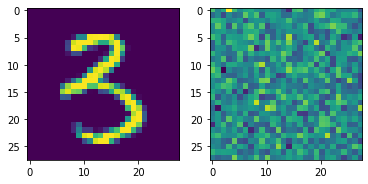

In [157]:
th_eval(model, ds_test, idx=5000)

In [172]:
loss_fn = th.nn.MSELoss()

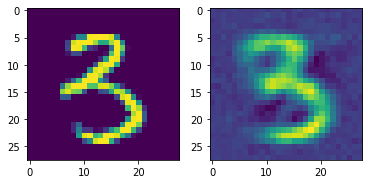

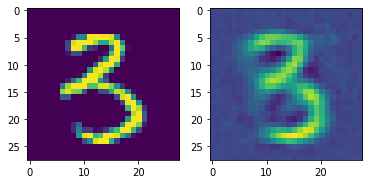

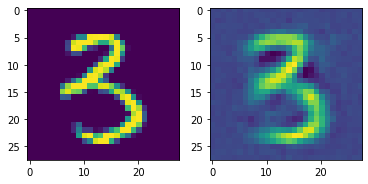

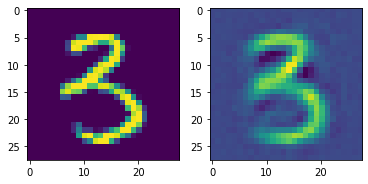

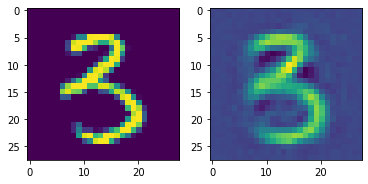

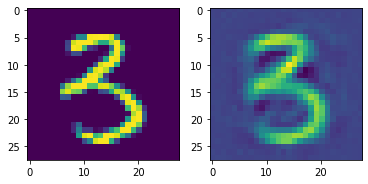

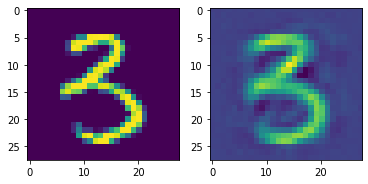

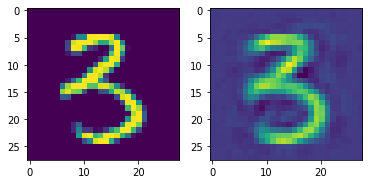

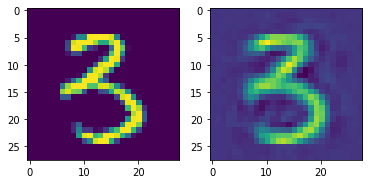

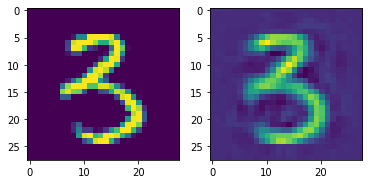

In [173]:
model = SimpleAutoEncoder(28*28).cuda()
opt = th.optim.Adam(params=model.parameters(), lr=0.001)
EPOCHS = 10
th_l1 = next(model.parameters())
for epoch in range(EPOCHS):
    cnt = 0
    for th_x_batch,  in dl:
        cnt += 1
        th_y_pred = model(th_x_batch)
        opt.zero_grad()
        th_loss = loss_fn(input=th_y_pred, target=th_x_batch.view(th_x_batch.shape[0], -1))
        th_loss.backward()
        opt.step()
    th_eval(model, ds_test, idx=5000)
    
        
    

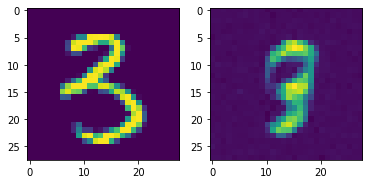

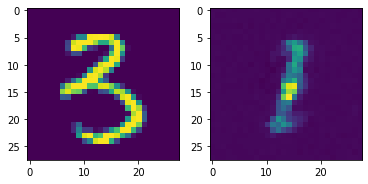

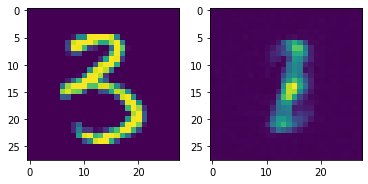

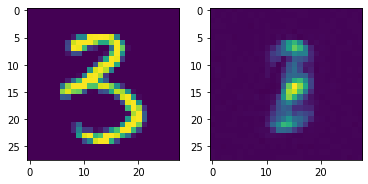

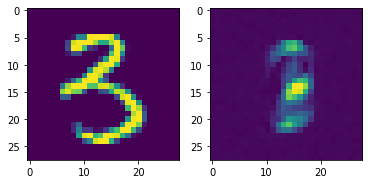

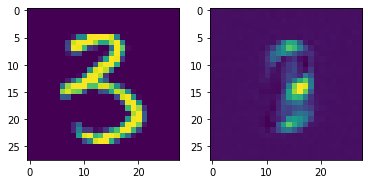

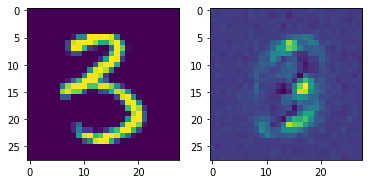

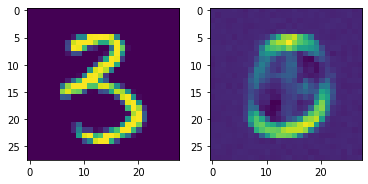

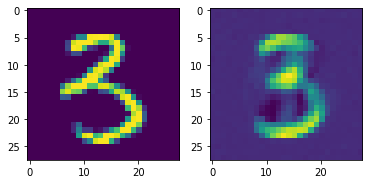

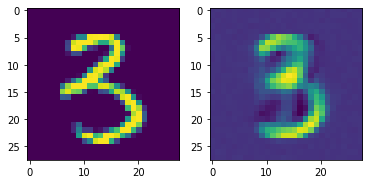

In [175]:
loss_fn = th.nn.L1Loss()
model = SimpleAutoEncoder(28*28).cuda()
opt = th.optim.Adam(params=model.parameters(), lr=0.0001)
EPOCHS = 10
th_l1 = next(model.parameters())
for epoch in range(EPOCHS):
    cnt = 0
    for th_x_batch,  in dl:
        cnt += 1
        th_y_pred = model(th_x_batch)
        opt.zero_grad()
        th_loss = loss_fn(input=th_y_pred, target=th_x_batch.view(th_x_batch.shape[0], -1))
        th_loss.backward()
        opt.step()
    th_eval(model, ds_test, idx=5000)
    
        

In [ ]:
# add dropout
# test encoding
# test decoding